# HW 4: Time Series and Tests of Independence

In This notebook we will
1. Generate random variable using the **rejection method**.
2. Analyze the **VIX** index of market volatility for independence of observations.
3. Use the inverse CDF method to draw samples from the **Risk Neutral** distribution of the SPX index.

## Preliminaries

### Imports

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize
from statsmodels.graphics.tsaplots import plot_acf

### Random Seed


In [111]:

seed=530228
gen=np.random.default_rng(seed)

### Data Directory

In [112]:
data_dir="../../data/yfinance"

### Code 

#### Up And Down Runs Test

In [113]:
def up_down_runs(S):
    slope=np.sign(np.diff(S))
    turns=( slope[:-1]!=slope[1:]) # compare sequence to sequence shifted by 1
    runs=np.sum(turns)+1
    return runs

In [114]:
def runs_up_score(S):
    N=len(S)
    R_bar=(2*N-1)/3
    sigma_R=np.sqrt((16*N-29)/90)
    R_hat=up_down_runs(S)
    Z_score=(R_hat-R_bar)/sigma_R
    return Z_score

#### Above/Below Mean Runs Test

In [115]:
def above_mean_runs(U):
    mu=U.mean()
    threshold=U>mu
    turns = threshold[:-1]!=threshold[1:] # shift by one and compare
    return np.sum(turns)+1

In [116]:
def runs_mean_score(U):
    mu=U.mean()
    threshold=U>mu
    n1=np.sum(threshold) # above threshold
    n2=len(U)-n1         # below threshold
    R_bar=2*(n1*n2)/(n1+n2)+1
    sigma_R=np.sqrt(2*n1*n2*(2*n1*n2-n1-n2)/(n1+n2)**2/(n1+n2-1))
    R_hat=above_mean_runs(U)
    Z_score=(R_hat-R_bar)/sigma_R
    return Z_score

#### Black-Scholes Formula


In [117]:
ndtr=stats.norm.cdf
epsilon=1e-12

def bs_price_fwd(isCall, K, T, F, sigma):
    """ Black's pricing formula
    
    European option  forward price as a function of
    the asset's forward.
    
    :param isCall: True for calls , False for Puts
    :type isCall: Boolean
    :param K: option strike
    :param T: option expiry in years
    :param F: forward of the options underlying asset
    :param sigma: underlying's  volatility
    :return: option's forward price
    """
    ds=np.maximum(0.000001,sigma*np.sqrt(T))
    dsig=0.5*ds*ds
    d2=(np.log(F/np.maximum(K,epsilon))-dsig)/ds
    d1=d2+ds
    if isCall:
        opt= F*ndtr(d1) - K*ndtr(d2)
    else:
        opt= K*ndtr(-d2) - F*ndtr(-d1)
    return opt

#### SVI Curve Parameterization 


In [118]:

class SVICurve:
    def __init__(self,T,F,vol_ATM,b,rho,m,sigma):
        self.T=T
        self.F=F
        self.a=vol_ATM**2*T-b*(-rho*m+np.sqrt(m**2+sigma**2)) 
        self.b=b
        self.rho=rho
        self.m=m
        self.sigma=sigma        
    def __call__(self,K):
        k=np.log(K/self.F)
        var=self.a + self.b*(self.rho*(k-self.m)+np.sqrt((k-self.m)**2+self.sigma**2))
        return np.sqrt(var/self.T)

#### Risk Neutral PDF/CDF Implementation

In [119]:
class RiskNeutral:
    def __init__(self,T,F,vol):
        self.T=T
        self.F=F
        self.vol=vol
    def cdf(self,K,dk=0.001):
        dK=K*dk
        K0=K-dK
        sig0=self.vol(K0)
        p0=bs_price_fwd(False,K0,self.T,self.F,sig0)
        K1=K+dK
        sig1=self.vol(K1)
        p1=bs_price_fwd(False,K1,self.T,self.F,sig1)
        return  (p1-p0)/dK/2.0
    def pdf(self,K,dk=0.001):
        dK=K*dk
        return (self.cdf(K)-self.cdf(K-dK))/dK

### Generation RiskNeutral Distribution Samples

In [120]:
# dist must be a RiskNeutral distribution
def generate_risk_neutral(dist,size,gen):
    U=gen.uniform(0,1,size)
    S=np.empty(size)
    for i1 in range(size):
        S[i1]=optimize.brentq(lambda S: dist.cdf(S)-U[i1],dist.F*0.01,3*dist.F)
    return S

## Problem 1: Von Misses Distribution and the Rejection Method

The **Von Misses**   distribution for an **angle** $\theta\in (-\pi,\pi)$ is parameterized in term of a single constant $\kappa$.

Its probability density function is defined by:
$$
    \text{PDF}_\kappa(\theta) = \frac{ \exp \left ( \kappa  \cos \theta\right)}{C}
$$
where $C$ is a normalization constant (depending on $k$):
$$
    C= \int_{-\pi}^\pi  \exp \left ( \kappa  \cos \theta\right) \, \text{d} \theta
$$

We will generate samples from the Von Misses distribution usin the **rejection method**.

### Problem 1.1

Define the **unnormalized** von-missed PDF
$$
    \widetilde{PDF}_k(\theta) = \exp \left( \kappa \cos \theta \right)
$$

 by implementing  the following function:

In [121]:
def von_misses_pdf(theta,k):
        pass

In [122]:
def von_misses_pdf(theta,k):
        return np.exp(k*np.cos(theta))

### Problem 1.2: 

1. Plot the unnormalized probability density function $\widetilde{PDF}$ for parameters $\kappa=0.2$, $\kappa=1$ and $\kappa=5$.
2. Without doing any other calculations, can you guess with one of the three parameters will have a higher rejection rate when generating samples using the rejection method?

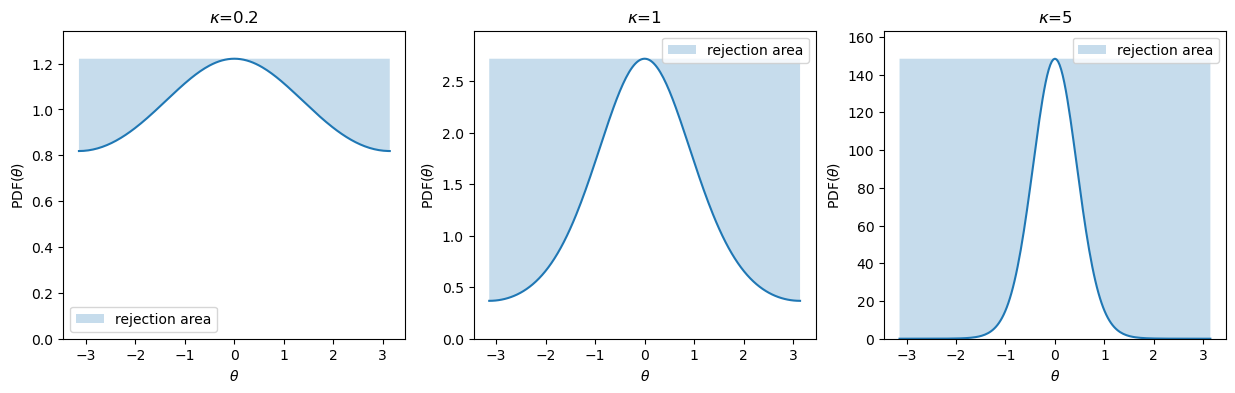

In [123]:
theta=np.linspace(-np.pi,np.pi,201)

pdf2=von_misses_pdf(theta,1)
pdf3=von_misses_pdf(theta,5)

plt.figure(figsize=(15,4))

plt.subplot(131)
k=0.2
pdf=von_misses_pdf(theta,k)
plt.title(fr"$\kappa$={k}")
plt.plot(theta,pdf)
plt.ylim(0,1.1*pdf.max())
plt.fill_between(theta,pdf,pdf.max(),alpha=0.25,label="rejection area")
plt.xlabel(r"$\theta$")
plt.ylabel(r"PDF($\theta$)")
plt.legend()

plt.subplot(132)
k=1
pdf=von_misses_pdf(theta,k)
plt.title(fr"$\kappa$={k}")
plt.plot(theta,pdf)
plt.ylim(0,1.1*pdf.max())
plt.fill_between(theta,pdf,pdf.max(),alpha=0.25,label="rejection area")
plt.xlabel(r"$\theta$")
plt.ylabel(r"PDF($\theta$)")
plt.legend()

plt.subplot(133)
k=5
pdf=von_misses_pdf(theta,k)
plt.title(fr"$\kappa$={k}")
plt.plot(theta,pdf)
plt.ylim(0,1.1*pdf.max())
plt.fill_between(theta,pdf,pdf.max(),alpha=0.25,label="rejection area")
plt.xlabel(r"$\theta$")
plt.ylabel(r"PDF($\theta$)")
plt.legend()

In [124]:
# The rejection regions grow as k gets larger.

### Problem 1.3

Implement a function that returns two valued:
1. an array of `size` elements from the **von Misses** distribution with parameter `k` using the rejection method.
2. The proportion of samples that were rejected in the process of generating the samples. 

[HINT] 
1. Remember, the range of the von Misses distribution is $\theta \in (-\pi,\pi)$
2. The maximum (mode) of the von Misses distribution is attained when $\theta=0$.

In [155]:
def generate_von_misses(k,size,gen):
    # implement rejection method here
    return theta, rejection_rate

In [156]:
def generate_von_misses(k,size,gen):
    Z=[]
    generated=0
    rejected=0
    mode=0
    M=von_misses_pdf(0,k)
    while 1:
        u1=2*np.pi*gen.uniform(0,1,size=1)[0]-np.pi
        u2=M*gen.uniform(0,1,size=1)[0]
        p=von_misses_pdf(u1,k)
        if u2<=p:
            Z.append(u1)
            generated+=1
        else:
            rejected+=1
        if generated==size:
            break
    rejection_rate=rejected/(rejected+size)
    return np.array(Z),rejection_rate

### Problem 1.4

Generate $N=1,000$ samples of the von Misses Distribution with parameter $\kappa=1$.
1. What was the rejection rate?
2. Make a histogram of the generated sample angles and compare it to the **normalized** PDF of the von Misses distribution.
3. Run the K-S test to verify that the generated samples are consistent with having a von Misses distribution.

[HINT] To generate the  normalized von-Misses PDF and CDF, you can use [scipy.stats.vonmisses](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.vonmises.html) random variable implementation.

In [126]:
N=1_000
k=1
Theta,rejected=generate_von_misses(k,N,gen)
rejected

0.5274102079395085

Text(0, 0.5, 'PDF($\\theta$)')

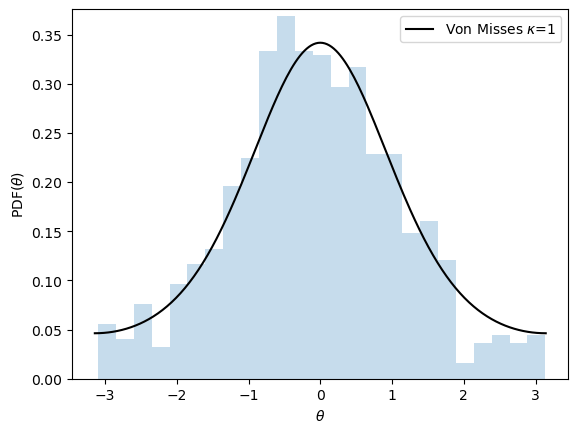

In [127]:
theta=np.linspace(-np.pi,np.pi,201)
dist=stats.vonmises(k)
pdf=dist.pdf(theta)
plt.hist(Theta,bins=25,alpha=0.25,density=True)
plt.plot(theta,pdf,"k",label=fr"Von Misses $\kappa$={k}")
plt.legend()
plt.ylim(0,1.1*pdf.max())
plt.xlabel(r"$\theta$")
plt.ylabel(r"PDF($\theta$)")

In [128]:
stats.kstest(Theta,dist.cdf)

KstestResult(statistic=0.0401782744592728, pvalue=0.07709368801263572)

### Problem 1.5

Repeat Problem 1.4 but this time with $\kappa=5$.

Generate $N=1,000$ samples of the von Misses Distribution:
1. What was the rejection rate?
2. Make a histogram of the generated sample angles and compare it to the **normalized** PDF of the von Misses distribution.
3. Run the K-S test to verify that the generated samples are consistent with having a von Misses distribution.

Did the rejection rate behave as you predicted in problem 1.2?

In [129]:
N=1_000
k=5
Theta,rejected=generate_von_misses(k,N,gen)
rejected

0.8245306194069135

Text(0, 0.5, 'PDF($\\theta$)')

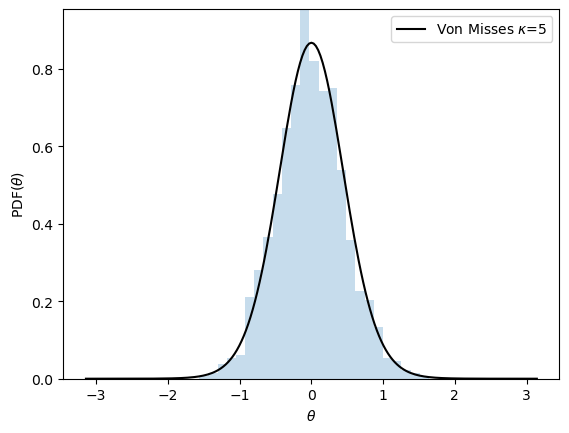

In [130]:
theta=np.linspace(-np.pi,np.pi,201)
dist=stats.vonmises(k)
pdf=dist.pdf(theta)
plt.hist(Theta,bins=25,alpha=0.25,density=True)
plt.plot(theta,pdf,"k",label=fr"Von Misses $\kappa$={k}")
plt.legend()
plt.ylim(0,1.1*pdf.max())
plt.xlabel(r"$\theta$")
plt.ylabel(r"PDF($\theta$)")

In [131]:
stats.kstest(Theta,dist.cdf)

KstestResult(statistic=0.031940937046904816, pvalue=0.2539396495620314)

## Problem 2: VIX Empirical Distribution

### Problem 2.1

Read the file `VIX.csv` into a Panda's `DataFrame`
1. We will only use the columns `Date` and `Close`.
2. Make sure the filed `Date` is  parsed as a date.

[NOTE] `VIX` is an index of the **one month SPX options implied volatility**. It tends to go up during periods of market distress. 

In [132]:
vix_raw=pd.read_csv(f"{data_dir}/VIX.csv",parse_dates=["Date"],index_col=["Date"],usecols=["Date","Close"])
vix_raw.head()
vix_raw.columns=["VIX"]
vix_raw.head()

,VIX
Date,
1998-02-11,20.379999
1998-02-12,19.730000
1998-02-13,19.840000
1998-02-17,20.760000
1998-02-18,19.660000


### Problem 2.2

Separate the VIX data into two DataFrames. 
1. A **training** dataFrame with data up to (but not including) `2022-02-09`
2. A **test** DataFrame with from `2022-02-09` to the last data available.
3. What periods of data do you have available for training (back-testing) and testing?


In [134]:
test_date='2022-02-09'

In [135]:
vix_train=vix_raw[(vix_raw.index<test_date) ]
vix_test=vix_raw[(vix_raw.index>=test_date) ]
vix_train.tail()

,VIX
Date,
2022-02-02,22.090000
2022-02-03,24.350000
2022-02-04,23.219999
2022-02-07,22.860001
2022-02-08,21.440001


In [136]:
vix_train.index[0],vix_train.index[-1]

(Timestamp('1998-02-11 00:00:00'), Timestamp('2022-02-08 00:00:00'))

### Problem 2.3

Plot the time series of  VIX levels during the training period.

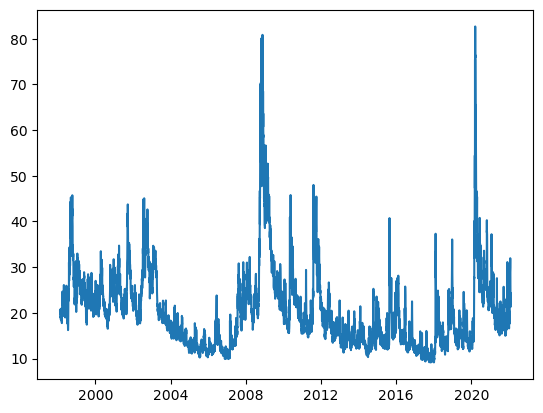

In [137]:
plt.plot(vix_train.index,vix_train["VIX"].values)

### Problem 2.4

1. Compute the daily changes  of VIX  during the training and testing periods.
2. Plot the time series of  VIX daily changes  during the **training** period.

[HINT] Do not compute the **percentage changes**,  but the level changes (difference) from day to day

In [157]:
dvix_train=vix_train.diff().dropna()
dvix_test=vix_test.diff().dropna()
dvix_train.head()

,VIX
Date,
1998-02-12,-0.650000
1998-02-13,0.110001
1998-02-17,0.920000
1998-02-18,-1.100000
1998-02-19,0.219999


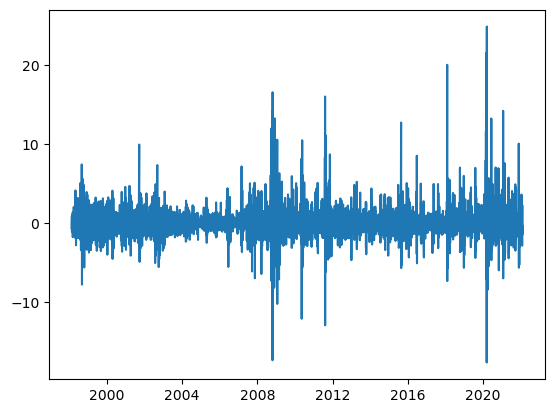

In [139]:
plt.plot(dvix_train.index,dvix_train["VIX"].values)

### Problem 2.5

Extract the **levels** and **daily changes** during the training period and during the testing period in four separate `numpy` arrays:
1. VIX Levels during training period.
2. VIX Levels during testing period.
3. VIX Changes during training period.
4. VIX Changes during testing period.

[HINTS]
1. Make sure the Arrays have only one index (like a vector).
2. For the rest of the problem set you should only use the `numpy` arrays, not the panda's DataFrame.

In [140]:
VIX=vix_train["VIX"].values
VIX_test=vix_test["VIX"].values
dVIX=dvix_train["VIX"].values
dVIX_test=dvix_test["VIX"].values

### Problem 2.6

1. Fit the **VIX  levels** during the training period to a **Gama** distribution (with three parameters).
2. Make a histogram plot of the VIX levels and compare it to the PDF of the fitted distribution.

In [160]:
f=stats.gamma.fit(VIX)
dist=stats.gamma(*f)
print(*f)

1.9011416303877904 9.112344033775546 5.917414912059423


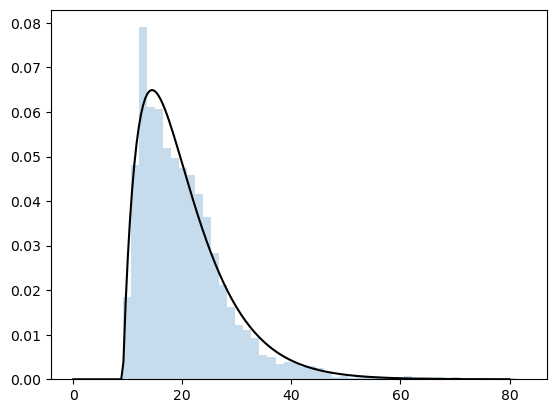

In [161]:
z=np.linspace(0,80,201)
plt.hist(VIX,bins=50,alpha=0.25,density=True)
plt.plot(z,dist.pdf(z),c="k")


### Problem 2.7

Perform the following statistical tests on the **training period VIX levels**:

1. K-S Distribution test againts the Student's T distribution you fitted.
2. Runs up and down/test
3. Runs above/below the Mean.

In [162]:
stats.kstest(VIX,dist.cdf)

KstestResult(statistic=0.021207366035451702, pvalue=0.008621940579787423)

In [163]:
runs_up_score(VIX)

-27.46158255611574

In [164]:
runs_mean_score(VIX)

-69.86402719915816

### Problem 2.8

1. Make an autocorrelation plot of the VIX levels during the training period.
2. Does any of the lag correlations seem significant? 

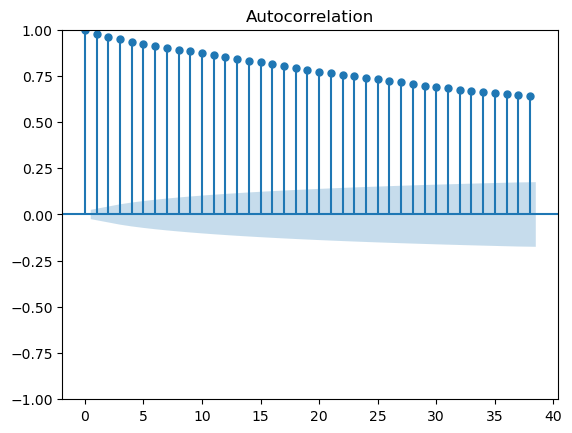

In [146]:
a=plot_acf(VIX)

### Problem 2.9

1. Perform tke K-S test to the VIX levels on the **testing** period, using the distrbution you fitted to **training** data.
2. Make a plot comparing the histograms during training and test period 
3. Can you describe any differences on the distributions?

In [147]:
stats.kstest(VIX_test,dist.cdf)

KstestResult(statistic=0.4944643074483798, pvalue=1.235482637522908e-57)

(array([0.01063662, 0.04254649, 0.05318312, 0.04254649, 0.09572961,
        0.09572961, 0.04254649, 0.10636623, 0.07445636, 0.08509299,
        0.08509299, 0.09572961, 0.10636623, 0.08509299, 0.04254649,
        0.06381974, 0.10636623, 0.08509299, 0.05318312, 0.04254649,
        0.06381974, 0.09572961, 0.12763948, 0.03190987, 0.05318312,
        0.09572961, 0.04254649, 0.04254649, 0.06381974, 0.04254649,
        0.04254649, 0.04254649, 0.06381974, 0.08509299, 0.04254649,
        0.04254649, 0.03190987, 0.06381974, 0.03190987, 0.05318312,
        0.02127325, 0.02127325, 0.03190987, 0.01063662, 0.        ,
        0.01063662, 0.01063662, 0.        , 0.        , 0.01063662]),
 array([17.87000084, 18.24160084, 18.61320084, 18.98480083, 19.35640083,
        19.72800083, 20.09960083, 20.47120083, 20.84280083, 21.21440083,
        21.58600082, 21.95760082, 22.32920082, 22.70080082, 23.07240082,
        23.44400082, 23.81560081, 24.18720081, 24.55880081, 24.93040081,
        25.30200081, 25.67

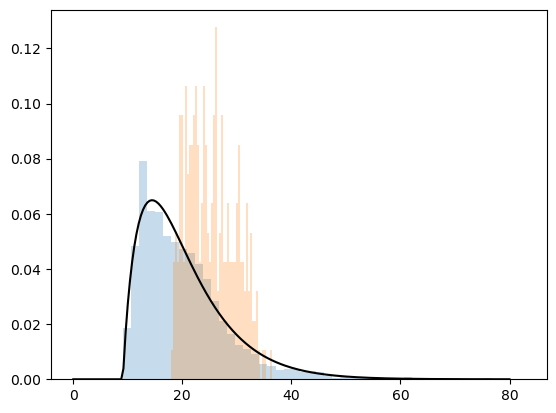

In [165]:
z=np.linspace(0,80,201)
plt.hist(vix_train,bins=50,alpha=0.25,density=True)
plt.plot(z,dist.pdf(z),c="k")
plt.hist(vix_test,bins=50,alpha=0.25,density=True)

In [ ]:
#  The vix level (a reflection of market volatility) has shifted significantly higheer over the last year.

## Bonus Problem 3: VIX Daily Changes

### Problem 3.1 
1. Fit the VIX  changes during the training period to a  distribution that you think fits well.
2. Make a histogram plot of the VIX levels and compare it to the PDF of the fitted distribution.

In [166]:
mu,sigma=stats.norm.fit(dVIX)
dist0=stats.norm(mu,sigma)

In [167]:
df,mu,sigma=stats.t.fit(dVIX)
dist=stats.t(df,mu,sigma)

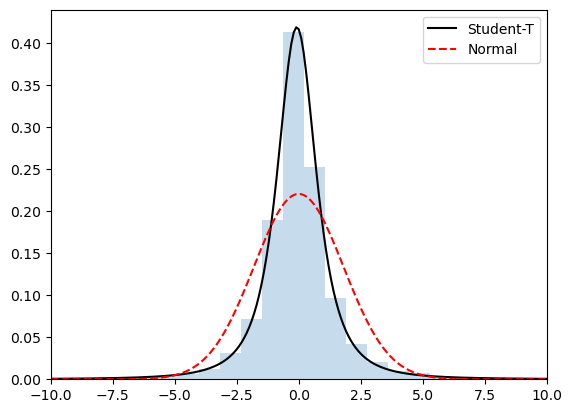

In [168]:
z=np.linspace(-10,10,201)
plt.hist(dVIX,bins=50,alpha=0.25,density=True)
plt.xlim(-10,10)
plt.plot(z,dist.pdf(z),c="k",label="Student-T")
plt.plot(z,dist0.pdf(z),"r--",label="Normal")
plt.legend()

In [169]:
# Student's T fits better.

### Problem 3.2

Perform the following statistical test on the training period VIX changes:

1. K-S Distribution test againts the Student's T distribution you fitted.
2. Runs up and down/test
3. Runs above/below the Mean.

In [170]:
stats.kstest(dVIX,dist.cdf)

KstestResult(statistic=0.017038750852577056, pvalue=0.05935442156260162)

In [171]:
runs_up_score(dVIX)

-0.4579005462543088

In [172]:
runs_mean_score(dVIX)

2.534683644454142

### Problem 3.3

1. Make an autocorrelation plot of the VIX levels.
2. Does any of the lag correlations seem significant? 

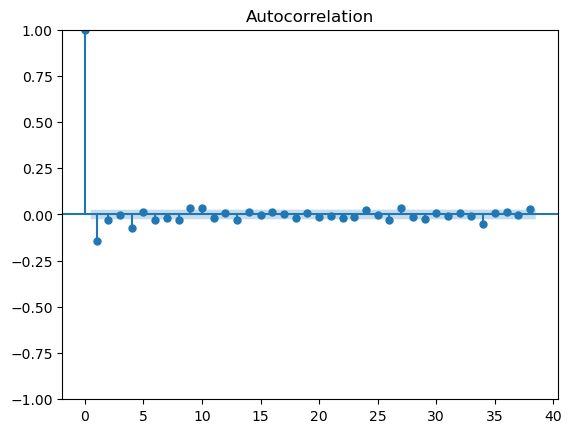

In [ ]:
a=plot_acf(dVIX)

In [ ]:
# The first lag is significantly negative.

### Problem 3.4

1. Perform tke K-S test to the VIX changes on the **testing** period, using the distribution to fitted to **training** data.
2. Make a plot comparing the histograms during training and test period 
3. Can you describe any differences on the distributions?

In [174]:
stats.kstest(dVIX_test,dist.cdf)

KstestResult(statistic=0.10677844597346053, pvalue=0.005891551728308022)

(array([0.01920742, 0.        , 0.        , 0.05762227, 0.01920742,
        0.05762227, 0.09603712, 0.05762227, 0.0768297 , 0.13445197,
        0.09603712, 0.21128167, 0.17286682, 0.3841485 , 0.36494107,
        0.3073188 , 0.32652622, 0.28811137, 0.24969652, 0.2304891 ,
        0.19207425, 0.1536594 , 0.1536594 , 0.3073188 , 0.11524455,
        0.1536594 , 0.09603712, 0.01920742, 0.03841485, 0.0768297 ,
        0.05762227, 0.        , 0.        , 0.01920742, 0.0768297 ,
        0.03841485, 0.01920742, 0.03841485, 0.        , 0.        ,
        0.03841485, 0.        , 0.01920742, 0.        , 0.        ,
        0.01920742, 0.01920742, 0.        , 0.01920742, 0.01920742]),
 array([-3.82999992, -3.62339993, -3.41679993, -3.21019993, -3.00359993,
        -2.79699993, -2.59039993, -2.38379993, -2.17719994, -1.97059994,
        -1.76399994, -1.55739994, -1.35079994, -1.14419994, -0.93759995,
        -0.73099995, -0.52439995, -0.31779995, -0.11119995,  0.09540005,
         0.30200005,  0.50

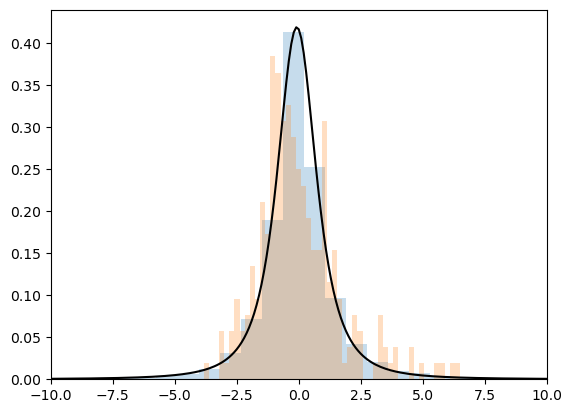

In [175]:
z=np.linspace(-10,10,201)
plt.hist(dVIX,bins=50,alpha=0.25,density=True)
plt.xlim(-10,10)
plt.plot(z,dist.pdf(z),c="k")
plt.hist(dVIX_test,bins=50,alpha=0.25,density=True)

In [176]:
# Mean seems slightly lower  and the tails wider, comparable to the SPX, but not nearly as bad as VIX levels.

## Bonus Problem 4: Generating Risk Neutral Samples

In this problem we will analyze a few of the statistical properties of risk-neutral samples

[HINT] All the **code** needed to implement SVI parameterization, define a Risk Neutral distribution and
generate samples from it is **included at the beginning of this notebook**.

### Problem 4.1

Define a SVI volatility Curve for one year options in the  SPX index using the following assumptions

1. Expiry $T=1$
2. Forward $F=4,200$
3. ATM volatility is 19\%
4. The other parameters of the SVI parametrization are given by:
    1. b=.13
    2. rho=.-734
    3. m=.128
    4. $\tilde{\sigma}$=0.118

This parameters where calibrated to market option data as of `2023-02-07`

**Plot the volatility surface** to verify that everything looks reasonable.

In [ ]:
T=1
F=4200
sigma_ATM=0.19
b=0.13
rho=-0.734
m=0.128
sigma=0.118

In [ ]:
vol=SVICurve(T,F,sigma_ATM,b,rho,m,sigma)

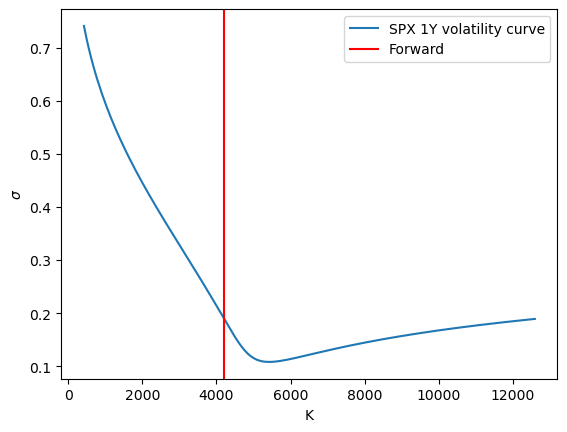

In [ ]:
K=np.linspace(0.1*F,3*F,201)
vols=vol(K)
plt.plot(K,vols,label="SPX 1Y volatility curve")
plt.axvline(F,c="r",label="Forward")
plt.xlabel("K")
plt.ylabel(r"$\sigma$")
plt.legend()

### Problem 4.2

Define the Risk Neutral Distribution  implied by the Vol Curve defined in Problem 4.1.

Plot the PDF of the risk neutral distribution.

[HINT] Use the  `RiskNeutral` class  defined at the beginning of this notebook ( on the `Code` section).
 

In [ ]:
dist=RiskNeutral(T,F,vol)


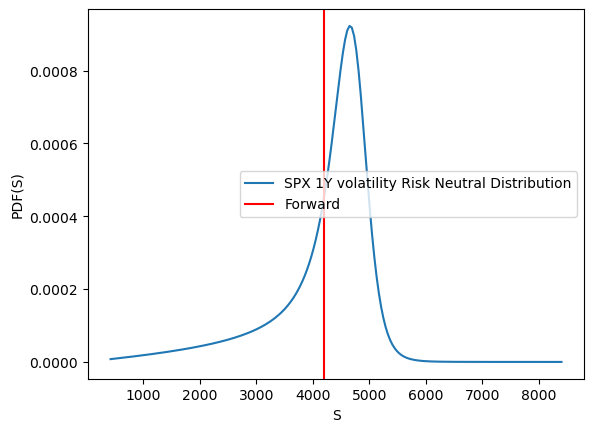

In [ ]:
S=np.linspace(0.1*F,2*F,201)
pdf=dist.pdf(S)
plt.plot(S,pdf,label="SPX 1Y volatility Risk Neutral Distribution")
plt.axvline(F,c="r",label="Forward")
plt.xlabel("S")
plt.ylabel("PDF(S)")
plt.legend()

### Problem 4.3

1. Generate $N=1,000$ samples from the risk neutral distribution you generated in problem 4.2.
2. Plot the histogram of the generated samples and compare it to the risk neutral PDF. 
3. Perform the K-S test to verity that the samples are consisted with the implied distribution.


In [ ]:
N=1_000
S_samples=generate_risk_neutral(dist,N,gen)

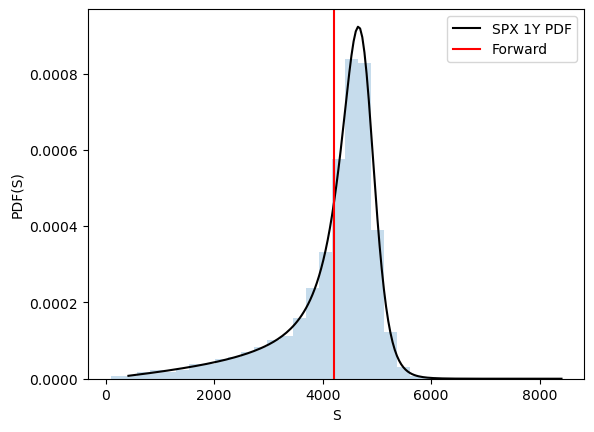

In [ ]:

S=np.linspace(0.1*F,2*F,201)
pdf=dist.pdf(S)
plt.hist(S_samples,bins=25,alpha=0.25,density=True)
plt.plot(S,pdf,c="k",label="SPX 1Y PDF")
plt.axvline(F,c="r",label="Forward")
plt.xlabel("S")
plt.ylabel("PDF(S)")
plt.legend()

In [ ]:
stats.kstest(S_samples,dist.cdf)

KstestResult(statistic=0.016733669751878177, pvalue=0.2102800468075453)

### Problem 4.4

Using the Central Limit Theorem as we discussed in Lecture 2.
1. What is the expected value of the **sample average**?
$$
    \hat{S} = \frac{1}{N}\sum_{i=1}^N S_i
$$
2. What is the variance of the sample average?
$$
    \text{Var}(\hat{S}) = \mathbb{E} \left[\left(\hat{S}-\mathbb{E}(\hat{S})\right)^2\right]
$$

Compute those values and argue if the difference betwwen **sample average** and expected value of sample average look reasonable.

[HINT] For this calculation you can assume that the variance of $S$ is well approximated by the **in sample variance** of $S$:
$$
     \text{sample\_var}= \frac{1}{N}\sum_{i=1}^N (S_i - \hat{S})^2 \approx \text{Var}(S)=\mathbb{E}\left[\left ( S - \mathbb{E}(S)\right)^2\right]
$$

In [177]:
# The expected value of S is the forward S
S_hat=S_samples.mean()
# the variance of the sample mean is the sum of N independend varibles.
# Its variacne should be
#  S_var/N, we do not know analytically the variance of S, but we can
# substitute by the variance on the sample
S_var=S_samples.var()
S_hat_var=S_var/N
S_hat_std=np.sqrt(S_hat_var)
S_hat,F, S_var,S_hat_std

(4180.125595664222, 4200, 797207.0662806218, 28.234855520803038)

In [178]:
# By the CLT we expect  Z=(S_hat-F)/sS_hat_std
# to have normal N(0,1) distribution
Z=(S_hat-F)/S_hat_std
Z

-0.7038960876259888

In [154]:
# This result is consistent at a 95\% confidence level because |Z|<2